In [1]:
# Initialize Otter
import otter
grader = otter.Notebook("cs1090a_hw3.ipynb")

# <img style="float: left; padding-right: 10px; width: 45px" src="https://raw.githubusercontent.com/Harvard-IACS/2018-CS109A/master/content/styles/iacs.png"> CS1090A Introduction to Data Science: 

## Homework 3: Polynomial and LASSO Regression

**Harvard University**<br/>
**Fall 2024**<br/>
**Instructors**: Pavlos Protopapas, Natesh Pillai, and Chris Gumb

<hr style="height:2.4pt">

In [2]:
# RUN THIS CELL 
import requests
from IPython.core.display import HTML
styles = requests.get(
    "https://raw.githubusercontent.com/Harvard-IACS/2021-CS109A/master/"
    "themes/static/css/cs109.css"
).text
HTML(styles)

<div style = "background: black; border: thin solid black; border-radius: 2px; padding: 5px">

### Instructions
- To submit your notebook, follow the instructions given in on the Canvas assignment page.
- Plots should be legible and interpretable *without having to refer to the code that generated them*. They should include labels for the $x$- and $y$-axes as well as a descriptive title and/or legend when appropriate.
- When asked to interpret a visualization, do not simply describe it (e.g., "the curve has a steep slope up"), but instead explain what you believe the plot *means*.
- Autograding tests are mostly to help you debug. The tests are not exhaustive so simply passing all tests may not be sufficient for full credit.
- The use of *extremely* inefficient or error-prone code (e.g., copy-pasting nearly identical commands rather than looping) may result in only partial credit.
- We have tried to include all the libraries you may need to do the assignment in the imports cell provided below. Please get course staff approval before importing any additional 3rd party libraries.
- Enable scrolling output on cells with slighlty longer output. Avoid excessively long output.
- Feel free to add additional code or markdown cells as needed.
- Don't forget to include a written response when one is requested by a question prompt.
- Ensure your code runs top to bottom without error and passes all tests by restarting the kernel and running all cells (note that this can take a few minutes). 
- **You should do a "Restart Kernel and Run All Cells" before submitting to ensure (1) your notebook actually runs and (2) all output is visible**
</div>

### Import Libraries

In [3]:
from collections import Counter
import math
import time

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.utils import shuffle

from warnings import simplefilter
simplefilter('ignore', category=FutureWarning)

In [4]:
# For calculating total notebook runtime
notebook_start = time.time()

<a id="contents"></a>

## Notebook contents

- [**Overview and data description**](#intro)


- [**Question 1: Data visualization [4 pts]**](#part1)

- [**Your Homework 3 roadmap**](#roadmap)


- [**Question 2: Guesstimate the polynomial relationship [22 pts]**](#part2)

- [**Question 3: Use a validation set to find the most promising polynomial relationship [12 pts]**](#part3)

- [**Question 4: Finding the best model by k-fold cross validation [14 pts]**](#part4)

- [**Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]**](#part5)

- [**Question 6: Improving model consistency with LASSO regularization [26 pts]**](#part6)

- [**Question 7: Analyze your best test MSEs for each section of the homework [6 pts]**](#part7)

<a id="intro"></a>

## Overview and data description

[Return to contents](#contents)

### Predicting percentage change in bacteria populations given their spreading factor

In this homework, we will explore polynomial regression for modeling a quantitative variable. Specifically, we will model the percent change in a bacteria population after 4 hours as a function of the bacteria's "spreading factor".

**The data set for this problem has already been split for you.** You will find the train and test data sets in the files `data/bacteria_train.csv` and `data/bacteria_test.csv`, respectively.

### Problem Description

We will predict the percentage change in population, given the spreading factor. Thus, we will consider the `Spreading_factor` to be our predictor variable and `Perc_population` to be our response variable. Using mean squared error ($MSE$) as an evaluative criteria, we will explore several different approaches for finding the best fit and most robust polynomial regression for modeling this relationship.

<a id="part1"></a>

## <div class='exercise'>Question 1: Data visualization [4 pts]</div> 
    
[Return to contents](#contents)
    

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.1</b></div>

Generate a *well-labeled* scatter plot of the data points in the `bacteria_train.csv` file with the spreading factor on the $x$-axis and the percentage change on the $y$-axis.

Text(0, 0.5, 'Percentage of Population')

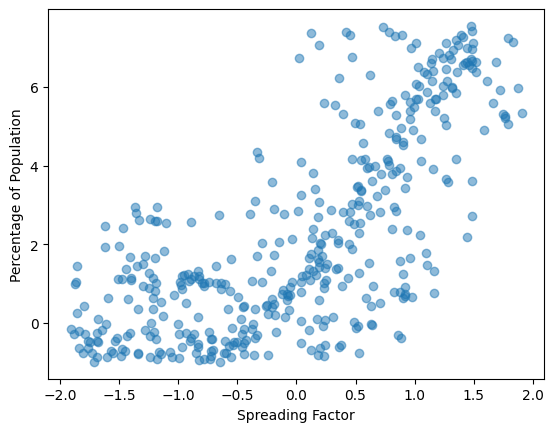

In [5]:
# your code here
# Load the data
path = r'C:\Users\khcod\OneDrive\Documents\Classes\APCOMP209a\cs1090a_hw3\data'
train = pd.read_csv(path + '/bacteria_train.csv')
test = pd.read_csv(path + '/bacteria_test.csv')

plt.scatter(train['Spreading_factor'], train['Perc_population'], alpha=0.5)
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage of Population')

In [6]:
train.head()

,Perc_population,Spreading_factor
0,1.535,0.190708
1,5.555,0.326928
2,-0.277,-0.459699
3,1.724,-0.193013
4,-0.550,-0.835745


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q1.2</b></div>

Based on the graph above, is there any discernable relationship between the spreading factor and percentage change in population? If so, how would you describe this relationship?

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The relationship between the spreading factor and percentage change in population is linear with a polynomial degree > 1 as the density of points shows a clear inflection point.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="roadmap"></a>

<hr style='height:2px'> 

## Your Homework 3 roadmap

[Return to contents](#contents)

**We will be following this roadmap throught the notebook**

![](./data/roadmap.png)


<a id="part2"></a>

## <div class='exercise'>Question 2: Guesstimate the polynomial relationship [22 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.1</b></div>

Based on your inspection in question 1, guesstimate the degree of the polynomial you believe would best fit the training while still generalizing well. Store this degree in the variable `guessed_deg`. 

Next, use `PolynomialFeatures()` to generate a design matrices of the guesstimated degree for the train and test data. Store these in `x_poly_train` and `x_poly_test`. 

**Notes:**
- **You don't need to scale your data in this assignment** (you can inspect the data to see why this might not be necessary)
- **You should *not* include a bias in the design matrix you intend to pass to the linear regression's `fit` method.**

In [7]:
# your code here
guessed_deg = 2

x_poly_train = PolynomialFeatures(degree=guessed_deg).fit_transform(train[['Spreading_factor']].values)
x_poly_test = PolynomialFeatures(degree=guessed_deg).fit_transform(test[['Spreading_factor']].values)

#drop col 1 from x_poly_train and x_poly_test
x_poly_train = x_poly_train[:,1:]
x_poly_test = x_poly_test[:,1:]


In [8]:
grader.check("q2.1")

q2.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.2</b></div>

Fit a polynomial regression using scikit-learn's `LinearRegression()` on the training design matrix. 

To track and compare the performance of each of the models in this notebook, use a list of dictionaries called `results`.

Each dictionary in this list will have the keys: 'model' (a string representing the question number where the model was fit), 'train_mse', and 'test_mse'.

So, for this question, you will append a dictionary to `results` of the form:
```python
{'model': '2.2', 'train_mse': 2.6749 'test_mse': 2.734}
```
Note that your MSE scores will not be the same as those in the example dictionary.

**Hint:** Because you will be calculating MSEs for models through this notebook, you may want to abstract this process into a function for re-use.

In [9]:
# Fit a linear regression model
lr = LinearRegression()

y_train = train['Perc_population'].values
y_test = test['Perc_population'].values
lr.fit(x_poly_train, y_train)

# create list of dicts
results = []


In [10]:
results.append({'model': '2.2', 'train_mse': mean_squared_error(y_train, lr.predict(x_poly_train)), 'test_mse': mean_squared_error(y_test, lr.predict(x_poly_test))})

In [11]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863


In [12]:
grader.check("q2.2")

q2.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.3</b></div>

- Create a plot showing both the train and test data, as well as your model's prediction curve.
- Display `results` as a DataFrame.
- Explain the rationale for your choice of degree (i.e. your "guesstimation") and comment on the fit of your model.
  

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The rationale for my choice of degree came from the singular visible inflection point in the first scatterplot of the train data. The fit of the model seems to fit the general trend based on the guessed degree but remains sensitive to noise and outliers towards higher levels of 'spreading factors', which reduces the model's ability to align with the true trend of the data.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

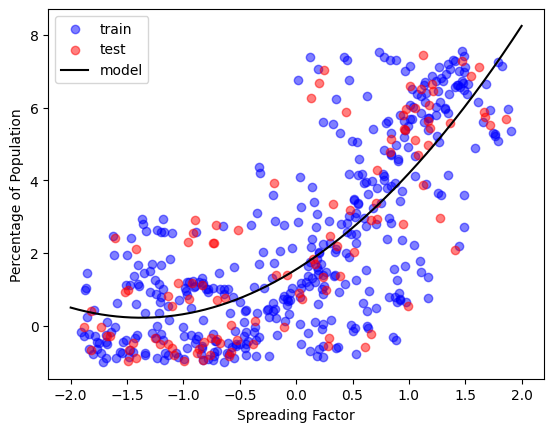

In [13]:
# your code here
x_range = np.linspace(-2,2, 1000).reshape(-1,1)
x_range_poly = PolynomialFeatures(degree=guessed_deg).fit_transform(x_range)[:,1:]
plt.scatter(train['Spreading_factor'], train['Perc_population'], alpha=0.5, color='blue', label='train')
plt.scatter(test['Spreading_factor'], test['Perc_population'], alpha=0.5, color='red', label = 'test')
plt.plot(x_range, lr.predict(x_range_poly), color='black', label='model')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage of Population')
plt.legend()
plt.show()

In [14]:
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.4</b></div>

Now we will compute confidence intervals for the coefficients generated by our model specification. For the same degree polynomial regression fit above in 2.2, compute and plot the 95% confidence interval of the beta (i.e. $\beta$) values obtained in that regression model. Be certain to meet these primary requirements:
- Report the coefficient values of the model fit above in 2.2.
- Use bootstrapping to generate your 95% confidence intervals by refitting your model to each bootstrapped sample of your training data. You should use **100 bootstrapped samples**.
- For each bootstrap, store the coefficients of the model, and use those stored coefficients to compute the $2.5$ and $97.5$ confidence bounds.
- Plot the bootstrapped coefficients as a grid of histograms, one histogram for each $\beta_i$, illustrating the distribution of bootstrapped coefficients for each $\beta_i$. Each distribution should indicate the regions of 95% confidence. Use `plt.subplots(...)` to arrange your histograms as a grid of plots.
- Comment on your findings.

**Note:** Our use of the term "coefficients" includes the intercept. So the intercept should also get a confidence interval plot.

**Hints:** Wrapping your plotting code in a function may make the solution to the next question more concise.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The bootstrap bounds and histogram show the high variability in model parameters, which makes sense as polynomial models have a higher variance than regular linear models.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [15]:
# report coef values of above model
print(f'coefficients: {lr.coef_}')
print(f'intercept: {lr.intercept_}')

coefficients: [1.93796806 0.70637891]
intercept: 1.5479189777983193


In [16]:
# create bootstrap function
def RandomUniverse(df):
    df_bootstrap = df.sample(df.shape[0], replace = True)
    return df_bootstrap

In [17]:
# compute 100 bootstrapped samples of training data

n_bootstraps = 100
bootstrap_samples = [RandomUniverse(train) for _ in range(n_bootstraps)]

bootstrap_samples[0]

,Perc_population,Spreading_factor
196,1.701,0.217568
400,5.305,1.744780
139,-0.998,-0.643884
233,0.787,0.877567
54,5.840,1.347620
...,...,...
231,-0.767,-0.592082
283,-0.262,-1.683770
85,7.202,1.345710
291,3.457,0.514951


In [18]:
#Use bootstrapping to generate your 95% confidence intervals by refitting your model to 
# each bootstrapped sample of your training data

coef_list = []
intercept_list = []

for bootstrap in bootstrap_samples:
    x_poly_train = PolynomialFeatures(degree=guessed_deg).fit_transform(bootstrap[['Spreading_factor']].values)
    x_poly_train = x_poly_train[:,1:]
    y_train = bootstrap['Perc_population'].values
    lr.fit(x_poly_train, y_train)
    coef_list.append(lr.coef_)
    intercept_list.append(lr.intercept_)

In [19]:
# use those stored coefficients to compute the $2.5$ and $97.5$ confidence bounds.
beta_1_list = [coef[0] for coef in coef_list]
beta_2_list = [coef[1] for coef in coef_list]

beta_0_bounds = np.percentile(intercept_list, [2.5, 97.5])
beta_1_bounds = np.percentile(beta_1_list, [2.5, 97.5])
beta_2_bounds = np.percentile(beta_2_list, [2.5, 97.5])

print(f'95% confidence interval for beta_0, beta_1, and beta 3: {[beta_0_bounds, beta_1_bounds, beta_2_bounds]}')

95% confidence interval for beta_0, beta_1, and beta 3: [array([1.33259056, 1.80635056]), array([1.78731539, 2.08777316]), array([0.54542681, 0.88582957])]


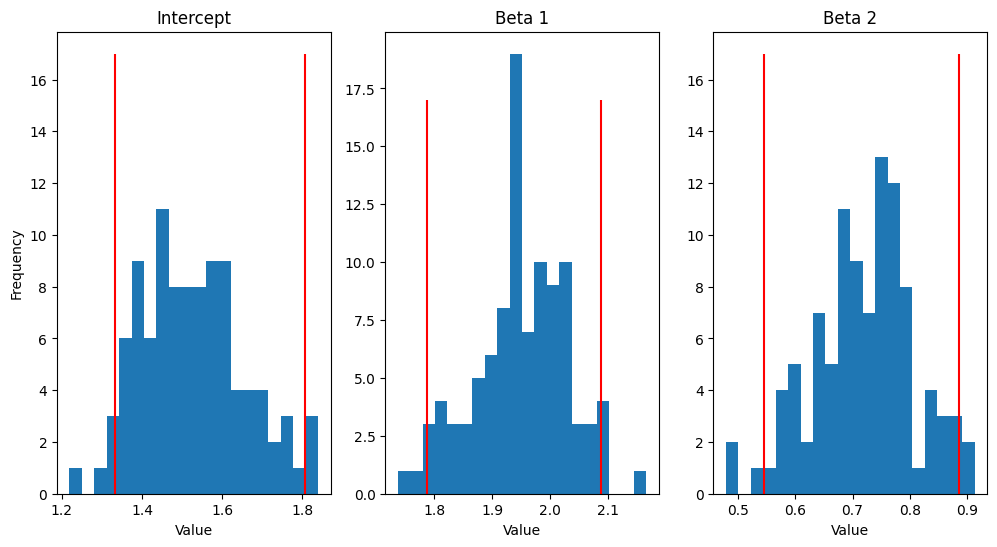

In [20]:
# Plot the bootstrapped coefficients as a grid of histograms, one histogram for each $\beta_i$,
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax = ax.ravel()

ax[0].hist(intercept_list, bins=20)
ax[1].hist(beta_1_list, bins=20)
ax[2].hist(beta_2_list, bins=20)

ax[0].set_title('Intercept')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[0].vlines(beta_0_bounds, 0, 17, color='red')
ax[1].set_title('Beta 1')
ax[1].set_xlabel('Value')
ax[1].vlines(beta_1_bounds, 0, 17, color='red')
ax[2].set_title('Beta 2')
ax[2].set_xlabel('Value')
ax[2].vlines(beta_2_bounds, 0, 17, color='red')



<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.5</b></div>

Linear regression can be viewed probabilistically, with deviations from the regression line attributed to an error term, $ \epsilon $, distributed as:

$$ \epsilon \sim N(0, \sigma^2) $$

In this question, you'll estimate confidence intervals for the regression coefficients based on this probabilistic perspective. Follow these steps:

1. Compute $ \hat{\sigma}_\epsilon^2 $, an estimate for the variance of the error term.
2. Utilizing this estimated variance, derive the standard errors for your regression coefficients.
3. Construct 95% confidence intervals for the coefficients using their standard errors. For the z-value, use 1.96.
4. Visualize the 95% confidence intervals alongside those from the bootstrap method. The values of the interval bounds should be made explicit in the plot.

**Hints:**
- Ensure your design matrix, $ X $, includes an intercept column to compute a confidence interval for $ \beta_0 $.
- Bootstrap samples play no role in this calculation.

In [21]:
# 1. Compute $ \hat{\sigma}_\epsilon^2 $, an estimate for the variance of the error term.

residuals = y_train - lr.predict(x_poly_train)

# Degrees of freedom: n - p
n = len(y_train)
p = x_poly_train.shape[1]

# Estimate the variance of the error term using sum of squared residuals
sigma_hat_squared = np.sum(residuals**2) / (n - p)

In [22]:
#2. Utilizing this estimated variance, derive the standard errors for your regression coefficients.
# add intercept to x_poly_train
X_poly_train_intercept = np.hstack([np.ones((x_poly_train.shape[0], 1)), x_poly_train])

# Compute the variance-covariance matrix of coefficients
XTX_inv = np.linalg.inv(X_poly_train_intercept.T@X_poly_train_intercept)
var_covar_matrix = sigma_hat_squared * XTX_inv

# standard error is square root of diagonol of var_covar_matrix
se = np.sqrt(np.diag(var_covar_matrix))
se

array([0.11819651, 0.08238434, 0.08879574])

In [23]:
# 3. Construct 95% confidence intervals for the coefficients using their standard errors. For the z-value, use 1.96.

z = 1.96
beta_0_upper = lr.intercept_ + z * se[0]
beta_0_lower = lr.intercept_ - z * se[0]

beta_1_upper = lr.coef_[0] + z * se[1]
beta_1_lower = lr.coef_[0] - z * se[1]

beta_2_upper = lr.coef_[1] + z * se[2]
beta_2_lower = lr.coef_[1] - z * se[2]

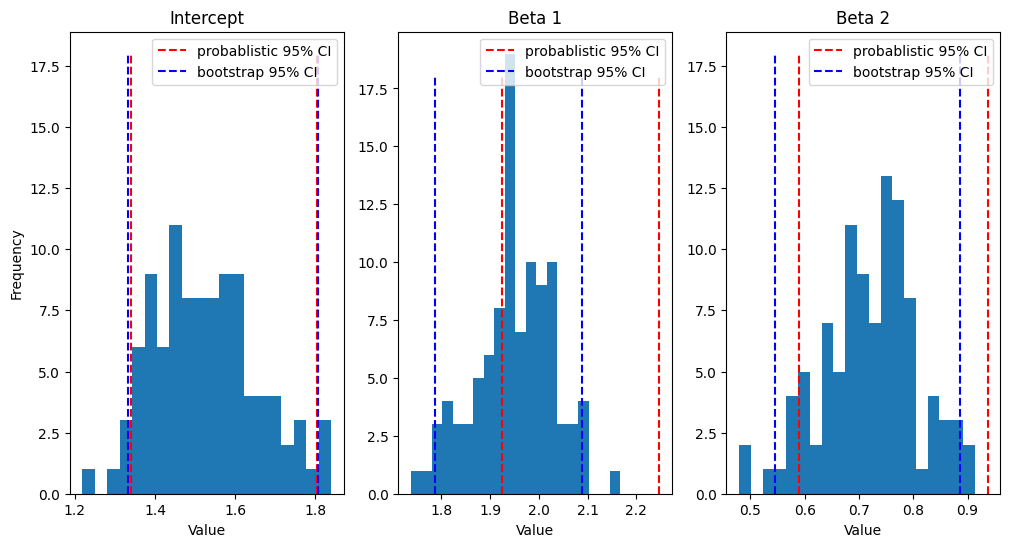

In [24]:
# 4. Visualize the 95% confidence intervals alongside those from the bootstrap method. The values of the interval bounds should be made explicit in the plot

# Plot the bootstrapped coefficients as a grid of histograms, one histogram for each $\beta_i$,
fig, ax = plt.subplots(1, 3, figsize=(12, 6))
ax = ax.ravel()

ax[0].hist(intercept_list, bins=20)
ax[1].hist(beta_1_list, bins=20)
ax[2].hist(beta_2_list, bins=20)

ax[0].set_title('Intercept')
ax[0].set_xlabel('Value')
ax[0].set_ylabel('Frequency')
ax[0].vlines([beta_0_lower, beta_0_upper], 0, 18, color='red', label='probablistic 95% CI', linestyle='--')
ax[0].vlines([beta_0_bounds[0], beta_0_bounds[1]], 0, 18, color='blue', label='bootstrap 95% CI', linestyle='--')
ax[0].legend()
ax[1].set_title('Beta 1')
ax[1].set_xlabel('Value')
ax[1].vlines([beta_1_lower, beta_1_upper], 0, 18, color='red', label='probablistic 95% CI', linestyle='--')
ax[1].vlines([beta_1_bounds[0], beta_1_bounds[1]], 0, 18, color='blue', label='bootstrap 95% CI', linestyle='--')
ax[1].legend()
ax[2].set_title('Beta 2')
ax[2].set_xlabel('Value')
ax[2].vlines([beta_2_lower, beta_2_upper], 0, 18, color='red', label='probablistic 95% CI', linestyle='--')
ax[2].vlines([beta_2_bounds[0], beta_2_bounds[1]], 0, 18, color='blue', label='bootstrap 95% CI', linestyle='--')
ax[2].legend()


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q2.6</b></div>

Reflect on the differences between the two sets of confidence intervals. Demonstrate at least one diagnostic making use of the model and/or training data to explore the potential reasons for any observed discrepancies in the confidence intervals. Be sure to explain the relevance of your diagnostic(s) to this particular task and interpret the results.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The difference between confidence intervals suggests that there may be biases within our parameter estimation. The diagnostic below shows that the model violates the homoscedasticity assumption as the residual variance increases as X increases. In order to increase accuracy of parameter estimation by reducing heteroscedasticity in residuals, we could consider log-transforming the dependent variable.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

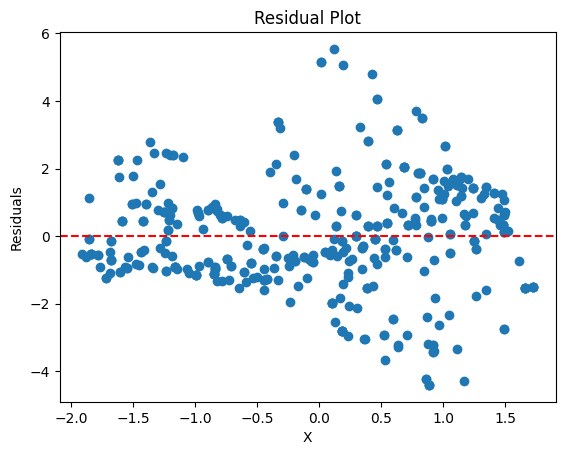

In [25]:
# Plot residuals as a function of x_train
plt.scatter(x_poly_train[:, 0], residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('X')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.show()

<!-- END QUESTION -->

<a id="part3"></a>

## <div class='exercise'>Question 3: Single validation set [12 pts]</div> 

In this section you'll find the best degree polynomial relationship using a single validation set.

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.1</b></div>

Split your original training data such that you separate out 20% into a single validation split. Use `random_state=1` and save the resulting splits as `x_train80`, `x_val`, `y_train80`, `y_val`. (This will prevent the overwriting of the original train data variables).

In [26]:
x_train = train[['Spreading_factor']].values

x_train80, x_val, y_train80, y_val = train_test_split(x_train, y_train, test_size=0.2, random_state=1)

In [27]:
grader.check("q3.1")

q3.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.2</b></div>

- Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set (one model for each degree polynomial regression).
- Store the train and validation MSE values for each model in lists called `train_mses` and `val_mses`.

In [28]:
# Fit polynomial regression models for **degrees 1 to 30 (inclusive)** on the 80% training set 
# (one model for each degree polynomial regression).

train_mses = []
val_mses = []

degree_list = np.arange(1, 31)
for d in degree_list:
    x_poly_train80 = PolynomialFeatures(degree=d).fit_transform(x_train80)
    x_poly_val = PolynomialFeatures(degree=d).fit_transform(x_val)
    lr.fit(x_poly_train80, y_train80)
    train_mses.append(mean_squared_error(y_train80, lr.predict(x_poly_train80)))
    val_mses.append(mean_squared_error(y_val, lr.predict(x_poly_val)))

In [29]:
grader.check("q3.2")

q3.2 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.3</b></div>

- Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model.
- Identify and report the degree for which the validation error is lowest.

**Note:** Plotting the MSE on a log scale may be helpful... 

Text(0.5, 1.0, 'Train and Validation MSE vs Degree of Polynomial Model')

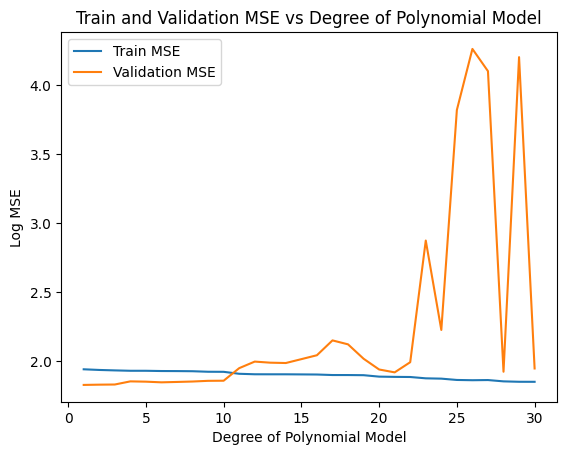

In [30]:
# Generate a single plot illustrating the train and validation $MSE$ values for each fitted degree polynomial regression model
#NOTE: used logarithmic scale because of large MSE outliers with high variance from high degree models

plt.plot(degree_list, np.log(train_mses), label='Train MSE')
plt.plot(degree_list, np.log(val_mses), label='Validation MSE')
plt.legend()
plt.xlabel('Degree of Polynomial Model')
plt.ylabel('Log MSE')
plt.title('Train and Validation MSE vs Degree of Polynomial Model')

In [31]:
# - Identify and report the degree for which the validation error is lowest.
val_mses = np.array(val_mses)
idx_min_val_mse = np.argmin(val_mses)
print(f"the degree value with the lowest validation MSE is {degree_list[idx_min_val_mse]}")

the degree value with the lowest validation MSE is 1


### NOTE 

The best degree output above changes with each run due to randomness, but I chose 17 as the best after the first run.

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.4</b></div>

Now, with the best degree selected, train the polynomial regression on the **complete training set** (including the observations that you had previously removed to make the validation set). 

Append a new dictionary to your `results` list for this model.

In [32]:
# train the polynomial regression on the **complete training set** 
# (including the observations that you had previously removed to make the validation set
x_test = test[['Spreading_factor']].values
y_train = train['Perc_population'].values
y_test = test['Perc_population'].values

x_poly_train = PolynomialFeatures(degree=17).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=17).fit_transform(x_test)

In [33]:
# create function that appends model number, train mse, and test mse to results list for later use
def results_append(model_num, x_tr, x_te, y_tr, y_te):
    '''appends model number, train mse, and test mse to results list for later use
    Args:model number, x_train, x_test, y_train, y_test
    Returns: results list
    '''
    lr.fit(x_tr, y_tr)
    results.append({'model': model_num, 'train_mse': mean_squared_error(y_tr, lr.predict(x_tr)), 'test_mse': mean_squared_error(y_te, lr.predict(x_te))})
    return results

In [34]:
results = results_append('3.4', x_poly_train, x_poly_test, y_train, y_test)

In [35]:
# Display your results thus far.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.489711,2.724142


In [36]:
grader.check("q3.4")

q3.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q3.5</b></div>

Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)). Comment on how your model fits the data and compare it to the fit of your "guesstimated" model from [Question 2](#part2solutions).

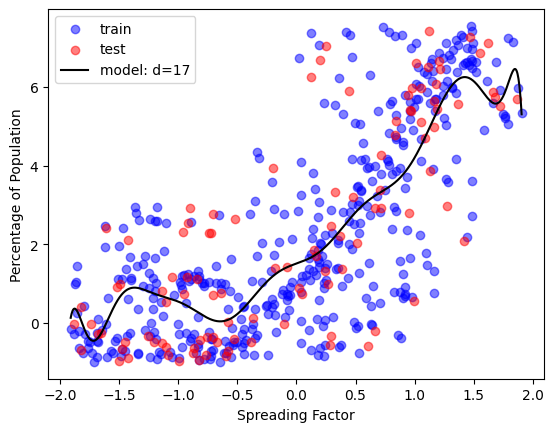

In [37]:
#refit lr to x_poly_train
lr.fit(x_poly_train, y_train)

x_range = np.linspace(np.min(train['Spreading_factor']),np.max(train['Spreading_factor']), 1000).reshape(-1,1)
x_range_poly = PolynomialFeatures(degree=17).fit_transform(x_range)
plt.scatter(train['Spreading_factor'], train['Perc_population'], alpha=0.5, color='blue', label='train')
plt.scatter(test['Spreading_factor'], test['Perc_population'], alpha=0.5, color='red', label = 'test')
plt.plot(x_range, lr.predict(x_range_poly), color='black', label='model: d=17')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage of Population')
plt.legend()
plt.show()

The above curve is less biased than the degree of 2 curve in question 2.3. However, this high degree polynomial model is much more sensitive to variance. This is because the curve of this model has many more inflection points. Additionally, because we only used one split instead of cross-validation to evaluate the best value for d, the curve appears to overfit on the validation points that happen to be clustered near the curve towards the higher end of spreading factors. I anticipate that this will change once we perform cross-validation.

<a id="part4"></a>

## <div class='exercise'>Question 4: Finding the best model by k-fold cross validation [14 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.1</b></div>

In this part we find the best degree polynomial regression by running the model on a range of degree values and using k-fold cross validation. Note that `cross_validation` should be passed *all* training examples (*not* the 80% split from the previous question).

- Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 (inclusive)**.
- For each degree:
    - store the mean train MSE across all $k$ folds in the list `train_mses_mean`
    - store the mean validation MSE across all $k$ folds in the list `val_mses_mean`
    - store the standard deviation  of the validation MSE across all $k$ folds in the list `val_mses_std`
    

In [38]:
# Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ for each polynomial regression from **degree 1 to 30 

train_mses_mean = []
val_mses_mean = []
val_mses_std = []

degree_list = np.arange(1, 31)
for d in degree_list:
    x_poly = PolynomialFeatures(degree=d).fit_transform(x_train)
    # set return train score to True to get train scores in output list
    cv = cross_validate(lr, x_poly, y_train, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

    # - cv because scoring is neg mean squared error
    train_mses_mean.append(-cv['train_score'].mean())
    val_mses_mean.append(-cv['test_score'].mean())
    val_mses_std.append(cv['test_score'].std())


In [39]:
grader.check("q4.1")

q4.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.2</b></div>

- Generate a single plot showing the mean train and validation $MSE$ values (see note below) for each degree polynomial regression, including the +/- 1 standard deviation bounds for the validation $MSE$ values.
- Comment on trends and findings illustrated by your plot.
- Print the degree of the best model, identified based on the lowest mean validation $MSE$, along with the corresponding mean train and validation $MSE$ values.

**NOTE:** When we refer to train and validation $MSE$ values here in Question 4.2 and in future problems where we are performing cross validation, we are referring specifically to the cross-validation generated train and validation $MSE$ values. Just please remember, when accessing your validation $MSE$ values while performing cross validation with scikit-learn's `cross_validate(...)`, scikit-learn rather confusingly refers to its validation scores as `test_score` in the dictionary that it returns, even though those values are actually validation scores. Please see the `cross_validate(...)` [documentation](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_validate.html) for more info on this function.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The plot below shows that the variance in MSE does clearly increase as degree increases. However, the average MSE is not lower, on average, in the higher degree models. Rather, the average MSE remains fairly constant until the degree is larger than 20.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

Text(0.5, 1.0, 'Mean Train and Validation MSE vs Degree across k=10 folds')

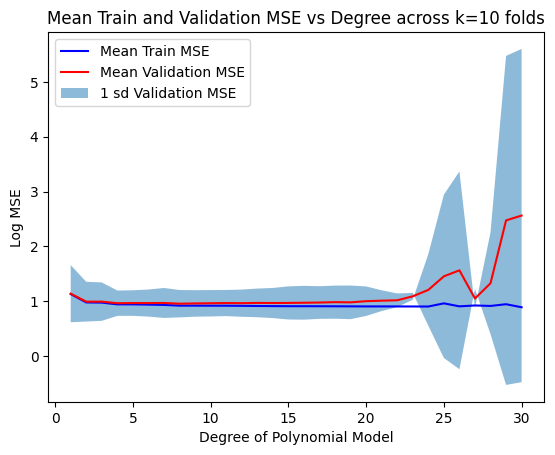

In [40]:
# Generate a single plot showing the mean train and validation $MSE$ values for each degree polynomial regression, 

plt.plot(degree_list, np.log(train_mses_mean), label='Mean Train MSE', color = 'blue')
plt.plot(degree_list, np.log(val_mses_mean), label='Mean Validation MSE', color = 'red')

# including the +/- 1 standard deviation bounds for the validation $MSE$ values
plt.fill_between(degree_list, np.log(val_mses_mean) - np.log(val_mses_std), np.log(val_mses_mean) + np.log(val_mses_std), alpha=0.5, label = '1 sd Validation MSE')
plt.legend()
plt.xlabel('Degree of Polynomial Model')
plt.ylabel('Log MSE')
plt.title('Mean Train and Validation MSE vs Degree across k=10 folds')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.3</b></div>

Fit the best model based on the entire training data and report the $MSE$.


- For the best degree polynomial regression identified in Question 4.2 above, train on the complete training data and predict on the test data.
- Append a new dictionary for this model to the `results` list. 

In [41]:
# get index of minimum validation mse
val_mses_mean = np.array(val_mses_mean)
idx_min_val_mse = np.argmin(val_mses_mean)
print(f"lowest validation MSE is degree {degree_list[idx_min_val_mse]}")

lowest validation MSE is degree 8


In [42]:
#train on the complete training data and predict on the test data
x_poly_train = PolynomialFeatures(degree=8).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=8).fit_transform(x_test)
results_append('4.3', x_poly_train, x_poly_test, y_train, y_test)

[{'model': '2.2',
  'train_mse': np.float64(2.661715130324048),
  'test_mse': np.float64(2.6748625754403093)},
 {'model': '3.4',
  'train_mse': np.float64(2.489711118646626),
  'test_mse': np.float64(2.7241417025970236)},
 {'model': '4.3',
  'train_mse': np.float64(2.5125174574727875),
  'test_mse': np.float64(2.613010637353014)}]

In [43]:
grader.check("q4.3")

q4.3 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q4.4</b></div>

- Generate a plot of the data and your regression curve (similar to [Question 2.3](#part2)).
- Display the coefficients of your model.
- Display `results` as a DataFrame (there should now be 3 entries).
- Comment on how your model fits the data and how your model compares relative to the prior best-fit model you generated using just a single validation set in [Question 3](#part3solutions).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The model is less sensitive to noise and thus overfits the validation set less than the model in question 3 that was generated using a single validation set. Less inflection points are noticable. Using 10 different validation sets across 10 folds helps us avoid this problem. 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

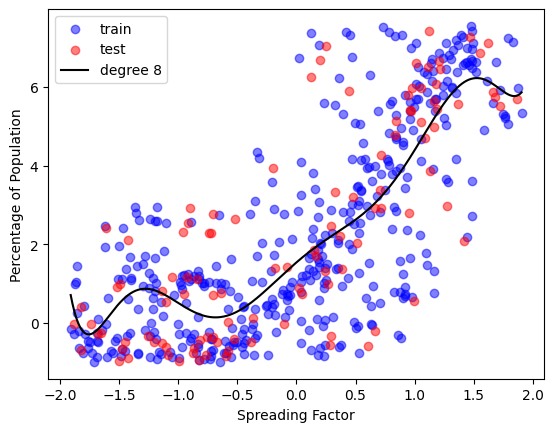

In [44]:
# Generate a plot of the data and your regression curve
lr.fit(x_poly_train, y_train)

x_range = np.linspace(np.min(train['Spreading_factor']),np.max(train['Spreading_factor']), 1000).reshape(-1,1)
x_range_poly = PolynomialFeatures(degree=8).fit_transform(x_range)
plt.scatter(train['Spreading_factor'], train['Perc_population'], alpha=0.5, color='blue', label='train')
plt.scatter(test['Spreading_factor'], test['Perc_population'], alpha=0.5, color='red', label = 'test')
plt.plot(x_range, lr.predict(x_range_poly), color='black', label='degree 8')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage of Population')
plt.legend()
plt.show()

In [45]:
 # Display the coefficients of your model.
lr.coef_

array([ 0.        ,  2.59702778, -1.09486847, -1.18913441,  3.48314914,
        0.65287664, -1.71300787, -0.11530516,  0.24041837])

In [46]:
# Display `results` as a DataFrame (there should now be 3 entries).
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.489711,2.724142
2,4.3,2.512517,2.613011


<!-- END QUESTION -->

<a id="part5"></a>

## <div class='exercise'>Question 5: Finding the most consistent model using k-fold cross validation with bootstraps [16 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.1</b></div>

In the previous part, we used $k$-fold cross validation to find the best model. But how confident are you of your estimated best degree? We have already used bootstraps in [Question 2.4](#part2) to estimate the confidence intervals of our $\beta_i$ values. In this segment, we will use bootstrapping to test the robustness of our estimation.

- Similar to Question 2.4, **use 100 bootstraps** of your data.
- For each bootstrap:
  - Use scikit-learn's `cross_validate(...)` to perform cross validation with $k=10$ *for each polynomial regression* of **degrees 1 to 30 (inclusive)**.
  - Select the best degree polynomial based on the lowest mean cross-validation MSE and store this degree in a list called `best_degrees`.
- After completing your bootstraps, `best_degrees` should have 100 elements, one degree for each completed bootstrap.

**NOTE:** Once complete, your code for this problem will likely take several minutes to execute. This is to be expected.

In [47]:
# 100 bootstraps to perform cross validation with $k=10$ *for each polynomial regression* of **degrees 1 to 30 (inclusive)**
best_degrees = []

# use bootstrap_samples which has 100 bootstrapped samples of training data
for bootstrap in bootstrap_samples:
    train_mses_mean = []
    val_mses_mean = []
    val_mses_std = []
    x_train = bootstrap[['Spreading_factor']].values
    y_train = bootstrap['Perc_population'].values
    for d in degree_list:
        x_poly = PolynomialFeatures(degree=d).fit_transform(x_train)
        # set return train score to True to get train scores in output list
        cv = cross_validate(lr, x_poly, y_train, cv=10, scoring='neg_mean_squared_error', return_train_score=True)

        # - cv because scoring is neg mean squared error
        train_mses_mean.append(-cv['train_score'].mean())
        val_mses_mean.append(-cv['test_score'].mean())
        val_mses_std.append(cv['test_score'].std())

    # get index of minimum validation mse
    idx_min_val_mse = np.argmin(np.array(val_mses_mean))
    best_degrees.append(degree_list[idx_min_val_mse])
        

In [48]:
# convert to int
best_degrees = [int(x) for x in best_degrees]

In [49]:
grader.check("q5.1")

q5.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.2</b></div>

Generate a well-labeled bar plot, with the polynomial degree on the $x$-axis and the number of times that degree was deemed best on the $y$-axis, using the `best_degrees` saved during your bootstraps.

**Hint:** You may want to make use of `Counter` which has been imported for your from the `collections` module of the standard Python library.

Text(0.5, 1.0, 'Frequency of Best Degree of Polynomial Model over 100 cross-validated bootstraps')

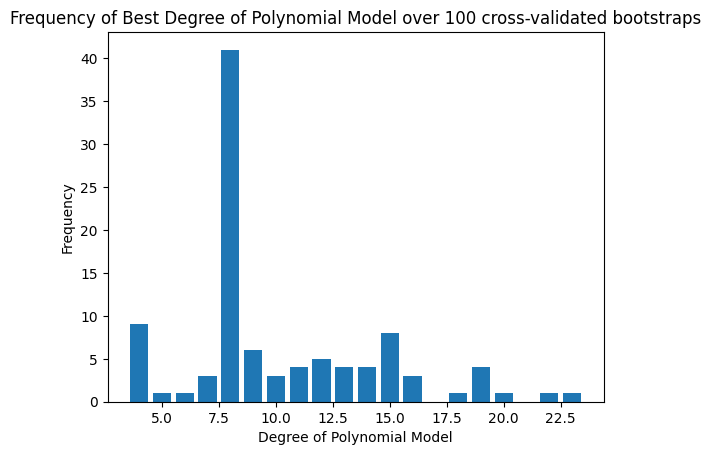

In [50]:
# get keys from Counter dictionary and plot their frequencies
plt.bar(Counter(best_degrees).keys(), Counter(best_degrees).values())
plt.xlabel('Degree of Polynomial Model')
plt.ylabel('Frequency')
plt.title('Frequency of Best Degree of Polynomial Model over 100 cross-validated bootstraps')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.3</b></div>

What are your observations from the plot above? 

- Why do you see so much variation in the "best degree" over the bootstraps?

- Which degree polynomial regression will you choose as your overall best degree based on your bootstrapped results, and why? 


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The bootstraps showed a clear preference for a degree of 8 based on minimizing the cross-validated mean squared error. However, all of the other degree values are nearly uniformly distributed. It is surprising that the data does not more closely resemble a normal distribution with higher values for 7 and 8, for example, due to the Central Limit Theorem.

So much variation occurs in the best degree because the idea of sampling with replacement means that observations can be duplicated, and due to stochasticity, certain observations being repeated many times or zero times can drastically chance the most optimal degree to minimize mean squared error on the validation set.

I will choose 8 because it is the clear mode of the barplot after 100 cross-validated bootstraps, suggesting that these results are not biased due to overfitting on a single validation set.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.4</b></div>

Now, with the overall best degree identified with your bootstrapping results above, train the polynomial regression model on the **complete training set**. Append a new dictionary for this model to your `results` list. 

In [51]:
# train the polynomial regression model on the **complete training set** with a degree of 8
# Append a new dictionary for this model to your `results` list. 

x_poly_train = PolynomialFeatures(degree=8).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=8).fit_transform(x_test)
results_append('5.4', x_poly_train, x_poly_test, y_train, y_test)

[{'model': '2.2',
  'train_mse': np.float64(2.661715130324048),
  'test_mse': np.float64(2.6748625754403093)},
 {'model': '3.4',
  'train_mse': np.float64(2.489711118646626),
  'test_mse': np.float64(2.7241417025970236)},
 {'model': '4.3',
  'train_mse': np.float64(2.5125174574727875),
  'test_mse': np.float64(2.613010637353014)},
 {'model': '5.4',
  'train_mse': np.float64(2.571688297373042),
  'test_mse': np.float64(2.5890926092999846)}]

In [52]:
grader.check("q5.4")

q5.4 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q5.5</b></div>

- Generate a plot of the data and your regression curve.
- Display `results` as a DataFrame.
- Comment on how your model fits the data and compare it to the fit of your cross-validated model from [Question 4](#part4solutions).

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The plot looks very similar to the cross-validated model from Question 4 because both use a degree of 8. However, there still seems to be skew towards outliers with a high spreading factor and lower percentage of population than expected by the general trend. A biologist may assume that this trend is due to randomness in the sample...

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

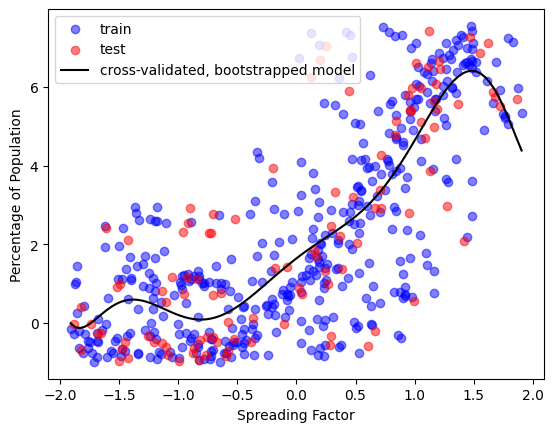

In [53]:
# get regression line for current model 
X_curve = np.linspace(train['Spreading_factor'].min(), train['Spreading_factor'].max(), 100).reshape(-1, 1)
X_curve_poly = PolynomialFeatures(degree=8).fit_transform(X_curve)
y_curve = lr.predict(X_curve_poly)

plt.scatter(train['Spreading_factor'], train['Perc_population'], alpha=0.5, color='blue', label='train')
plt.scatter(test['Spreading_factor'], test['Perc_population'], alpha=0.5, color='red', label='test')
plt.plot(X_curve, y_curve, color='black', label='cross-validated, bootstrapped model')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage of Population')
plt.legend()
plt.show()

In [54]:
# Display `results` as a DataFrame.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.489711,2.724142
2,4.3,2.512517,2.613011
3,5.4,2.571688,2.589093


<!-- END QUESTION -->

<a id="part6"></a>

## <div class='exercise'>Question 6: Improving model consistency with LASSO regularization [26 pts]</div> 

[Return to contents](#contents)

In the previous sections, we compared many polynomial models to find the best degree. For each model of degree $n$, we considered all polynomial coefficients *up to and including* **degree $n$** using `PolynomialFeatures(...)`. In this section we will consider polynomial features of $n=30$, and a **best model** that could be chosen from any possible combination of our 30 degrees.

For instance, we could choose a best model with an arbitrary set of polynomial degrees up degree 30, such as $x^i \in [x^1, x^5, x^{19}, x^{24}]$, rather than the standard approach of using *all* consecutive degrees up to our maximum degree $n=30$ as in $x^i \in [x^1, ... , x^{30}]$.

However, the total number of such possible models for $n=30$ is $2^{30}\approx10^9$, and searching through all of them would be laborious and computationally inefficient. Instead, we can use $LASSO$ (i.e. $L1$) regularization, which "switches off" highly unstable degree coefficients by shrinking them to zero (or very close to zero), thus giving us an efficient solution to this particular combinatorial challenge.

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.1</b></div>

**Find the best hyper-parameter alpha, $\alpha$**

Use the `LassoCV` estimator to find the best regularization parameter from $\alpha \in [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}]$
- Store the mean cross-validation MSEs across each fold in `lassoCV_val_mses_mean`
- Save the best $\alpha$ based on the mean cross-validation MSE in `best_alpha`

You should read the documentation for [LassoCV](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LassoCV.html). Some important information about this estimator:
- After calling `fit`, the model is now the one fit on the entire training data using the best alpha based on the mean CV MSE.
- the `mse_path_` attribute contains the validation scores on each fold for each candidate alpha.
- the `alpha_` attribute contains the best regularization parameter found through cross-validation

**Tips:** You should try adjusting `LassoCV`'s `max_iter` argument to prevent convergence warnings. If you are unable to prevent them with a large number of iterations (~100,000) then you can silence them with:
```{python}
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
```
Do not worry about normalizing your $x$ values for any parts of Question 6. It will not meaningfully affect our final results here.

In [57]:
# Use the `LassoCV` estimator to find the best regularization parameter from $\alpha \in [10^{-5}, 10^{-4}, 10^{-3}, 10^{-2}, 10^{-1}]$

alphas = [10**-5, 10**-4, 10**-3, 10**-2, 10**-1]

# Store the mean cross-validation MSEs across each fold in `lassoCV_val_mses_mean`
lasso_cv = LassoCV(alphas=alphas, cv=10)

#consider polynomial features of $n=30$
x_poly_train = PolynomialFeatures(degree=30).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=30).fit_transform(x_test)

#Save the best $\alpha$ based on the mean cross-validation MSE in `best_alpha`
lasso_cv.fit(x_poly_train, y_train)
lassoCV_val_mses_mean = np.array([np.mean(list_mses) for list_mses in lasso_cv.mse_path_])
idx_min_mses = np.argmin(lassoCV_val_mses_mean)
best_alpha = lasso_cv.alphas_[idx_min_mses]    


C:\Users\khcod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 583.4204308683541, tolerance: 0.2588410727431579
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\khcod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 492.1268009470123, tolerance: 0.2588410727431579
  model = cd_fast.enet_coordinate_descent_gram(
C:\Users\khcod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:683: ConvergenceWar

In [58]:
lassoCV_val_mses_mean

array([2.67776139, 2.61727109, 2.62492377, 2.63224242, 2.63591797])

In [91]:
grader.check("q6.1")

q6.1 results: All test cases passed!

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.2</b></div>

Generate two plots:
- One showing the mean validation $MSE$ values for each regularization parameter $\alpha$, identifying the best $\alpha$.
- Another showing the values of each coefficient in the LASSO model using the best $\alpha$. 

Text(0.5, 1.0, 'Coefficient Value vs Degree of Coefficient X^i for best alpha LASSO model')

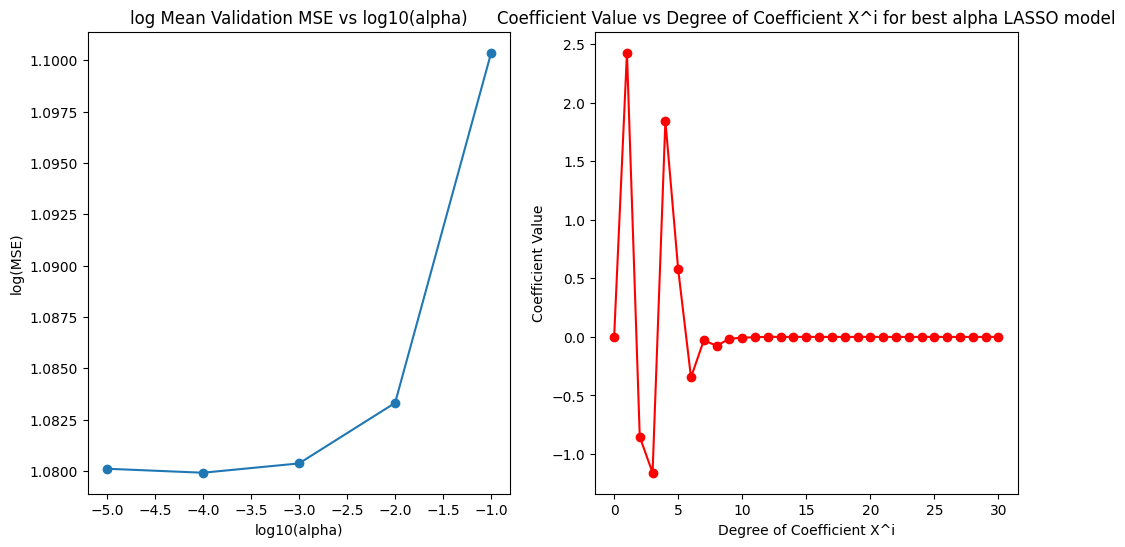

In [92]:
# plot mean validation $MSE$ values for each regularization parameter $\alpha$, identifying the best $\alpha$
fig,ax = plt.subplots(1,2, figsize=(12,6))
ax[0].plot(np.log10(lasso_cv.alphas_), np.log(lassoCV_val_mses_mean), label='Mean Validation MSE', marker='o')
ax[0].set_xlabel('log10(alpha)')
ax[0].set_ylabel('log(MSE)')
ax[0].set_title('log Mean Validation MSE vs log10(alpha)')

# plot values of each coefficient in the LASSO model using the best $\alpha$
ax[1].plot(range(0,31), lasso_cv.coef_, marker='o', color='red')
ax[1].set_xlabel('Degree of Coefficient X^i')
ax[1].set_ylabel('Coefficient Value')
ax[1].set_title('Coefficient Value vs Degree of Coefficient X^i for best alpha LASSO model')

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.3</b></div>

**Find the most significant degrees**

**NOTE: The code for this question has been provided. It can take several minutes to run. Just be sure to answer the interpretation part of the question.**

From the previous section, you will now have the `best_alpha` hyperparameter. Now, we will use this best $\alpha$ value to find the "most significant" set of polynomial degrees by using bootstraps.

What we mean by this is, for each bootstrap of the data, you will get some set of degrees that are **significant**, as will be indicated by the value of their coefficients. Typically, while using $LASSO$ regularization, we would consider $\mid\beta_i\mid \gt 0$ as an indication of a particular coefficient's significance. However, for this particular exercise, we are going to use $\mid\beta_i\mid \gt 0.1$ as our criteria for significance (we have found this $0.1$ threshold to work well when designing this particular problem).

Based on this criteria, you will identify which degree coefficients are significant over many bootstrapped iterations with $n=30$ polynomial features and your chosen best $\alpha$ from Question 6.1.

- Use polynomial features with **degree 30**.
- Use a dictionary called `significant_degrees` to store a cumulative count for each degree identified as significant during your bootstraps.
- Run at least 100 bootstraps of your data.
- For each bootstrap:
  - Train a `Lasso(...)` model with the `best_alpha` identified in Question 6.1.
  - Identify the significant polynomial degree coefficients using $\mid\beta_i\mid \gt 0.1 $ as our threshold for significance.
  - For each significant coefficient, update the count of that degree in your `significant_degrees` dictionary.
- Generate a bar plot showing the count for each degree, showing how many times it was identified as significant over your bootstraps.
- Based on this plot, there should likely be a clear maximum degree, above which, few if any iterations have been identified as significant. Interpret your bar plot, choose a maximum degree polynomial based upon it, and explain your rationale for choosing that degree.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The maximum degree polynomial is 8 based on the barplot below. Given our significance level of $\mid\beta_i\mid \gt 0.1$, the random bootstrap samples that do favor higher degree polynomials due to random chance and overfitting as seen in earlier questions with histograms of best degrees to minimize mean squared error are reduced. Thus, the barplot below does not show any maximum degree polynomials above 8, which agrees with our best degree from cross-validation before regularization.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<>:55: SyntaxWarning: invalid escape sequence '\m'
<>:55: SyntaxWarning: invalid escape sequence '\m'
C:\Users\khcod\AppData\Local\Temp\ipykernel_2944\1614806114.py:55: SyntaxWarning: invalid escape sequence '\m'
  f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
C:\Users\khcod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.416e+02, tolerance: 2.980e-01
  model = cd_fast.enet_coordinate_descent(
C:\Users\khcod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase th

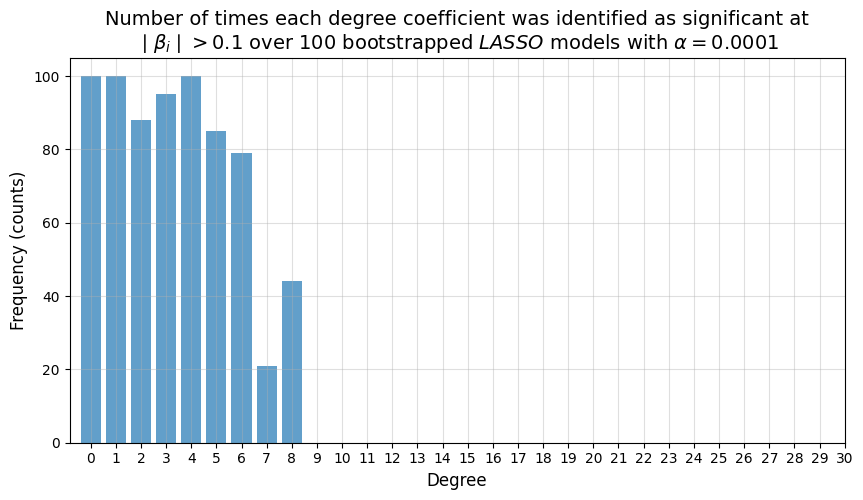

In [93]:
# your code here
# Set bootstrapping parameters
numboot = 100
max_degree = 30

significant_degrees = {}

# Perform bootstraps
df_train = pd.read_csv('data/bacteria_train.csv')

include_bias = False # No column of ones from PolynomialFeatures
fit_intercept = True # We will get it from LinearRegression.fit()

for i in range(numboot):
    df_boot = df_train.sample(frac=1, replace=True)
    x_train_boot = df_boot[["Spreading_factor"]]
    x_poly_train_boot = PolynomialFeatures(
        max_degree, include_bias=include_bias
    ).fit_transform(x_train_boot)
    y_train_boot = df_boot.Perc_population

    lasso = Lasso(
        fit_intercept=fit_intercept,
        max_iter=5_000,
        alpha=best_alpha,
    )
    lasso.fit(x_poly_train_boot, y_train_boot)
    
    if fit_intercept==True:
        coefficients = [lasso.intercept_, *lasso.coef_]
    else:
        # If you got your constant from PolynomialFeatures and not LinearRegression,
        # then the intercept is actually the first coef in the model.
        # But this would be problematic when using regularization. Can you see why?
        coefficients = lasso.coef_

    for i in np.where(np.abs(coefficients)>0.1)[0]:
        if i not in significant_degrees.keys():
            significant_degrees[i]=1
        else:
            significant_degrees[i]+=1

fig, ax = plt.subplots(figsize=(10,5))

lists = sorted(significant_degrees.items())

x, y = zip(*lists)

ax.bar(x, y, alpha=0.7)
ax.set_xlabel("Degree", fontsize=12)
ax.set_ylabel("Frequency (counts)", fontsize=12)
ax.set_xticks(range(max_degree+1))
ax.set_title(
    "Number of times each degree coefficient was identified as significant at\n"
    f"$\mid\\beta_i\mid > 0.1$ over {numboot} bootstrapped $LASSO$ models "
    f"with $\\alpha={best_alpha}$",
    fontsize=14,
)
plt.grid(":", alpha=0.4)

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.4</b></div>

From our Question 6.3 results, we can see that only some degrees are consistently significant over many bootstraps.

- Use polynomial features based on the maximum degree you identified using your results from Question 6.3 (for the sake of simplicity, use all degrees up to that maximum degree as is typically done in polynomial regression).
- Train your **LASSO** regularized model using your `best_alpha` hyper-parameter on the entire training set.
- Append a new dictionary for this model to your `results` list.

In [94]:
#  Use polynomial features based on the maximum degree you identified using your results from Question 6.3 
# (for the sake of simplicity, use all degrees up to that maximum degree as is typically done in polynomial regression)

x_poly_train = PolynomialFeatures(degree=8).fit_transform(x_train)
x_poly_test = PolynomialFeatures(degree=8).fit_transform(x_test)

# Train your **LASSO** regularized model using your `best_alpha` hyper-parameter on the entire training set
lasso = Lasso(alpha=best_alpha)
lasso.fit(x_poly_train, y_train)

# Append a new dictionary for this model to your `results` list.
# avoid using function that uses lr created above: results_append
results.append({'model': '6.4', 'train_mse': mean_squared_error(y_train, lasso.predict(x_poly_train)), 'test_mse': mean_squared_error(y_test, lasso.predict(x_poly_test))})

C:\Users\khcod\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\sklearn\linear_model\_coordinate_descent.py:697: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 6.100e+02, tolerance: 2.856e-01
  model = cd_fast.enet_coordinate_descent(


In [95]:
results

[{'model': '2.2',
  'train_mse': 2.661715130324048,
  'test_mse': 2.6748625754403093},
 {'model': '3.4',
  'train_mse': 2.489711118646626,
  'test_mse': 2.7241417025970236},
 {'model': '4.3',
  'train_mse': 2.5125174574727875,
  'test_mse': 2.613010637353014},
 {'model': '5.4',
  'train_mse': 2.8453949673049492,
  'test_mse': 2.6571732195522078},
 {'model': '6.4',
  'train_mse': 2.9149611882514215,
  'test_mse': 2.6297568148798574}]

In [96]:
grader.check("q6.4")

q6.4 results: All test cases passed!

<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.5</b></div>

- Generate a plot of the data and your regression curve.
- Report the polynomial degrees and corresponding coefficients for this fully trained model that have an absolute value greater than 0.1 (i.e. $\mid\beta_i\mid \gt 0.1 $)
- Display `results` as a DataFrame.

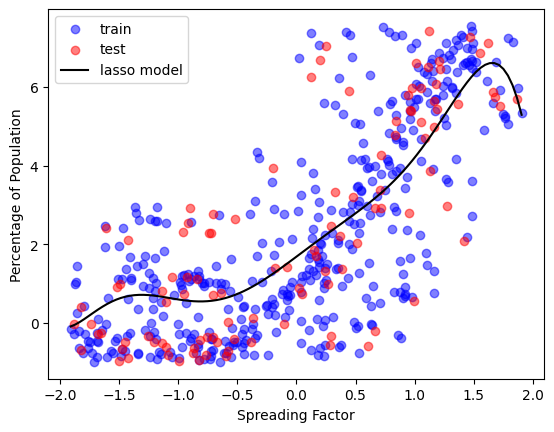

In [97]:
# Generate a plot of the data and your regression curve
X_curve = np.linspace(train['Spreading_factor'].min(), train['Spreading_factor'].max(), 100).reshape(-1, 1)
X_curve_poly = PolynomialFeatures(degree=8).fit_transform(X_curve)
y_curve = lasso.predict(X_curve_poly)

plt.scatter(train['Spreading_factor'], train['Perc_population'], alpha=0.5, color='blue', label='train')
plt.scatter(test['Spreading_factor'], test['Perc_population'], alpha=0.5, color='red', label='test')
plt.plot(X_curve, y_curve, color='black', label='lasso model')
plt.xlabel('Spreading Factor')
plt.ylabel('Percentage of Population')
plt.legend()
plt.show()


In [98]:
# Report the polynomial degrees and corresponding coefficients 
# for this fully trained model that have an absolute value greater than 0.1 (i.e. $\mid\beta_i\mid \gt 0.1 $)
idx_significant = lasso.coef_ > np.abs(0.1)
print(f"significant degrees for the trained polynomial model: {np.where(idx_significant)}")

significant degrees for the trained polynomial model: (array([1, 2, 4, 5], dtype=int64),)


In [99]:
# Display `results` as a DataFrame.
pd.DataFrame(results)

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.489711,2.724142
2,4.3,2.512517,2.613011
3,5.4,2.845395,2.657173
4,6.4,2.914961,2.629757


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q6.6</b></div>

**What are your observations?**

- Compare your `best_degree` from [Question 5](#part5solutions) with your chosen degree in 6.4 above and comment on the difference.
- Compare your test $MSE$ in this question with the result from question 5. Which one is smaller, and by how much?
- Which degree coefficients in your best fit model from 6.4 are significant? If not all coefficients are significant, why?
- Would you expect your current model from 6.4 to be more "reliable" or robust than the models in Question 5 and prior? On what basis would you make a claim of its robustness?


<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

The best_degree from question 5 and chosen_degree in 6.4 did not differ, which suggests that 8 provides the best trade-off between overfitting and underfitting. 

The test_mse for question 6 is slightly smaller by about 0.1. This is likely due to the reduction of overfitting by Lasso.

significant degrees are [1, 2, 4, 5] from the 6.4 model and not all 8 of the degree coefficients are significant because as seen by the barplot of frequency of each degree being significant over all bootstraps, Lasso just reduces less significant terms for any giving sample. Thus, 3, 6, 7, and 8 were reduced to a threshold below 0.1 for the given train set that the lasso object was fit on.

I would say that the model from 6.4 is more robust because 
1) the error term is lowest for the cross validated model in question 4 and nearly equal to the mean squared error in question 6
2) Since both models in question 6 and 4 reduce bias equally, the model from 6.4 is more robust because the simpler model created by regularization has less variance and thus is more generalizable to other data. 

For instance, the simpler model is less likely to be overfitted on the test set, which could create issues if the model is used on another test set of bacterial data.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<a id="part7"></a>

## <div class='exercise'>Question 7: Analyze your best test MSEs for each sub section of the homework [6 pts]</div> 

[Return to contents](#contents)

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.1</b></div>

Using the `results` list, generate a bar plot illustrating the test $MSE$ values for each of the models. Display `results` as a Dataframe as well.

Text(0.5, 1.0, 'Test MSE for each model')

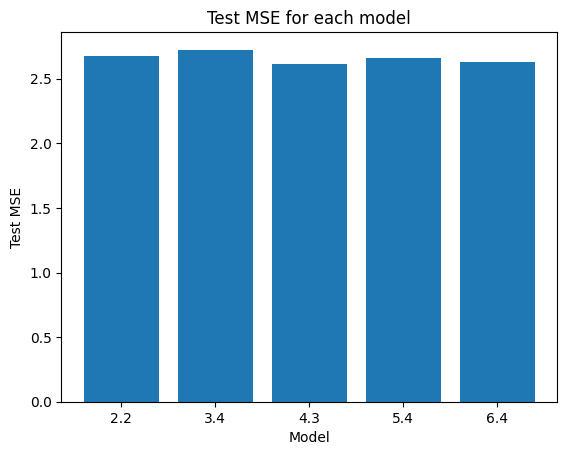

In [100]:
# convert results list to df
results_df = pd.DataFrame(results)
plt.bar(results_df['model'], results_df['test_mse'])
plt.xlabel('Model')
plt.ylabel('Test MSE')
plt.title('Test MSE for each model')


In [101]:
results_df

,model,train_mse,test_mse
0,2.2,2.661715,2.674863
1,3.4,2.489711,2.724142
2,4.3,2.512517,2.613011
3,5.4,2.845395,2.657173
4,6.4,2.914961,2.629757


<!-- END QUESTION -->

<!-- BEGIN QUESTION -->

<!-- BEGIN QUESTION -->

<div class='exercise'><b>Q7.2</b></div>

Which model do you think is best, and why? What are some of that model's drawbacks compared to the other models? 

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I still think that the final model in 6.4 is best. I believe this because the simpler model of a lower degree as output in question 6 above with degrees [1,2,4,5] is less vulnerable to overfitting and high variance. However, some drawbacks of this model could include the potential loss of signal due to the intensity of Lasso regression. Additionally, given that our threshold for each $\beta^n$ was only 0.1, one could argue that higher degree coefficients could play a role in the true trend of the data. Therefore, Lasso regularization, which is often used to reduce coefficients to 0, could be used differently and include coefficients that are greater than 0 but below 0.1 in order to better capture the trend of the data. Other models are heavily sensitive to training data trends, so the other models may be better choices for this problem if the sample size increased.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

<!-- END QUESTION -->

<div class="alert alert-info" style="color: #4a4a4a; background-color: #fbe8ff; border-color: #eed4db; border-width: 1px; border-radius: 3px; padding: 10px;">

**Wrap-up**

* Please describe the aspect(s) of the assignment you found most challenging. This could be conceptual and/or related to coding and implementation. This is also a good place to ask any remaining questions you may have.

* How many hours did you spend working on this assignment? Store this as an int or float in `hours_spent_on_hw`. If you worked on the project in a group, report the *average* time spent per person.

</div>

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

I found the conceptual questions most challenging, especially with the volatility of some of these polynomial models. The coding was definitely the most challenging during the bootstrapping portion, but helper functions, including those provided by the instructors and TF's, definitely made the process smoother.

<div class="highlight-box" style="border: 1px solid #ffcccb; background-color: #ffcccb; height: 5px;"></div>

In [102]:
hours_spent_on_hw = 10

In [103]:
grader.check("wrapup")

wrapup results: All test cases passed!

In [104]:
notebook_end = time.time()
print(f"It took {(notebook_end - notebook_start)/60:.2f} minutes for this notebook to run")

It took 22.96 minutes for this notebook to run


🌈 **This concludes HW3. Thank you!**

[Return to contents](#contents)